In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, roc_auc_score, mean_squared_error, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Reading male measurement data
data_raw = pd.read_csv("ANSUR II MALE Public.csv", header=0)

In [3]:
data_raw.head()

,subjectid,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,...,Branch,PrimaryMOS,SubjectsBirthLocation,SubjectNumericRace,Ethnicity,DODRace,Age,Heightin,Weightlbs,WritingPreference
0,10027,266,1467,337,222,1347,253,202,401,369,...,Combat Arms,19D,North Dakota,1,NaN,1,41,71,180,Right hand
1,10032,233,1395,326,220,1293,245,193,394,338,...,Combat Support,68W,New York,1,NaN,1,35,68,160,Left hand
2,10033,287,1430,341,230,1327,256,196,427,408,...,Combat Support,68W,New York,2,NaN,2,42,68,205,Left hand
3,10092,234,1347,310,230,1239,262,199,401,359,...,Combat Service Support,88M,Wisconsin,1,NaN,1,31,66,175,Right hand
4,10093,250,1585,372,247,1478,267,224,435,356,...,Combat Service Support,92G,North Carolina,2,NaN,2,21,77,213,Right hand


In [5]:
# Selecting relevant measurement columns for t-shirts
shirt_df = data_raw[["cervicaleheight", "chestbreadth", "chestcircumference", "chestdepth", "chestheight", "elbowrestheight",
         "forearmcenterofgriplength", "forearmcircumferenceflexed", "forearmforearmbreadth", "forearmhandlength",
         "abdominalextensiondepthsitting", "acromionradialelength", "biacromialbreadth", "bicepscircumferenceflexed", 
         "bicristalbreadth", "bideltoidbreadth", "waistbreadth", "waistcircumference", "waistdepth", "waistfrontlengthsitting",
         "wristcircumference", "wristheight", "Heightin", "neckcircumferencebase", "shoulderlength", "waistbacklength", 
         "hipbreadth", "hipbreadthsitting", "interscyei", "interscyeii"]]

In [33]:
# checking for duplicates
sum(shirt_df.duplicated())

0

In [6]:
# Checking data types and missing/null values
shirt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4082 entries, 0 to 4081
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   cervicaleheight                 4082 non-null   int64
 1   chestbreadth                    4082 non-null   int64
 2   chestcircumference              4082 non-null   int64
 3   chestdepth                      4082 non-null   int64
 4   chestheight                     4082 non-null   int64
 5   elbowrestheight                 4082 non-null   int64
 6   forearmcenterofgriplength       4082 non-null   int64
 7   forearmcircumferenceflexed      4082 non-null   int64
 8   forearmforearmbreadth           4082 non-null   int64
 9   forearmhandlength               4082 non-null   int64
 10  abdominalextensiondepthsitting  4082 non-null   int64
 11  acromionradialelength           4082 non-null   int64
 12  biacromialbreadth               4082 non-null   int64
 13  bic

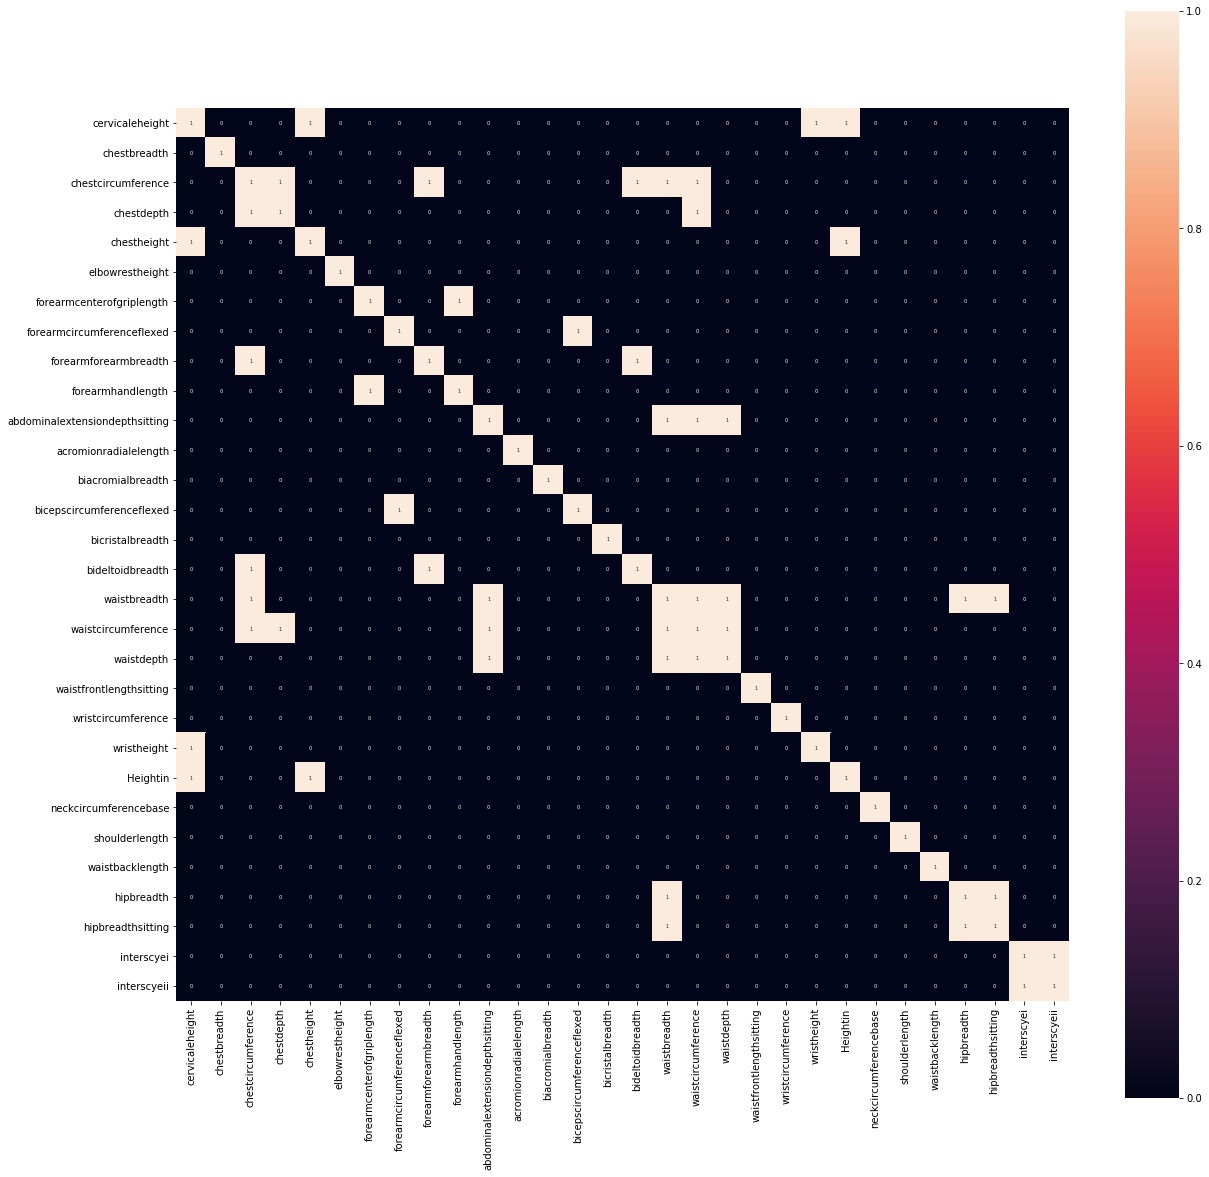

In [10]:
# Correlation heatmap to remove highly correlated measurements
plt.figure(figsize=(20,20))
ax = sn.heatmap(shirt_df.corr().abs().round(2)>=0.85, 
                 annot=True, annot_kws = { "size" : 5 }, square=True, cbar=True)

In [12]:
# Filtering out highly correlated variables leaves us with 13 measurements
shirt_new = shirt_df[["Heightin", "neckcircumferencebase", "shoulderlength", "biacromialbreadth",
             "interscyei", "acromionradialelength", "forearmhandlength", "chestbreadth",
             "chestcircumference", "bicepscircumferenceflexed", "bicristalbreadth",
             "waistfrontlengthsitting", "wristcircumference"]]

In [13]:
# Bringing all measurements to the same scale for clustering
mms = MinMaxScaler()
mms.fit(shirt_new) 
shirt_scaled = pd.DataFrame(mms.transform(shirt_new),
                        columns = shirt_new.columns)

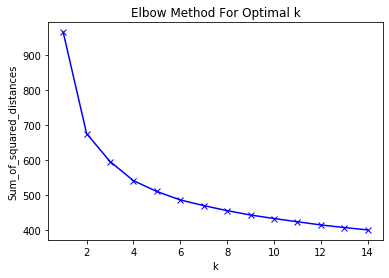

In [14]:
# Calculating sum of squared distances to find optimal number of clusters using elbow method
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(shirt_scaled)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [15]:
# Using kmeans to find clusters
kmeans = KMeans(n_clusters=6)
kmeans.fit(shirt_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [16]:
# Labeling clusters
shirt_scaled["cluster"] = kmeans.labels_

In [17]:
shirt_scaled["cluster"].value_counts()

4    870
2    817
0    719
5    702
1    490
3    484
Name: cluster, dtype: int64

### Classification using Logistic Regression and Random Forest to find Feature Importance

In [18]:
# Splitting scaled data into train test
x_train, x_test, y_train, y_test = train_test_split(
    shirt_scaled.drop(['cluster'],axis=1), shirt_scaled['cluster'], test_size=.25, random_state=42)

In [19]:
# Running Logistic Regression on train data
model_logit = LogisticRegression()
model_logit.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
# using the model to make predictions with the test data
y_pred = model_logit.predict(x_test)
# calculating model fit
round(model_logit.score(x_train,y_train)*100,3)


95.622

In [21]:
# Classification Results on Test Data
print("Mean Squared Error",round(mean_squared_error(y_test,y_pred),3))
print("-"*100)
print(confusion_matrix(y_test, y_pred))
print("-"*100)
print(classification_report(y_test, y_pred))

Mean Squared Error 0.204
----------------------------------------------------------------------------------------------------
[[166   2   1   0   3   0]
 [  4 118   0   0   4   0]
 [  1   0 195   0   2   0]
 [  0   0   4 124   0   8]
 [  1   0   1   0 202   0]
 [  0   0   4   1   6 174]]
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       172
           1       0.98      0.94      0.96       126
           2       0.95      0.98      0.97       198
           3       0.99      0.91      0.95       136
           4       0.93      0.99      0.96       204
           5       0.96      0.94      0.95       185

    accuracy                           0.96      1021
   macro avg       0.96      0.95      0.96      1021
weighted avg       0.96      0.96      0.96      1021



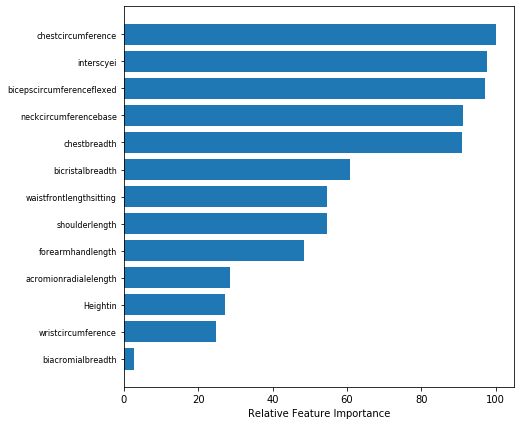

In [23]:
# Calculating feature importance from Logistic Regression Results
feature_importance_l = abs(model_logit.coef_[0])
feature_importance_l = 100.0 * (feature_importance_l / feature_importance_l.max())
sorted_idx = np.argsort(feature_importance_l)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(7,7))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance_l[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(shirt_scaled.drop(['cluster'],axis=1).columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.show()

In [24]:
# Running RandomForecast for classification
model_rf = RandomForestClassifier(random_state=42, class_weight='balanced')
model_rf.fit(x_train,y_train)

print("Accuracy on train set",round(model_rf.score(x_train,y_train)*100,3),"%")
print("Accuracy on test set",round(model_rf.score(x_test,y_test)*100,3),"%")

rf_pred = model_rf.predict(x_test)
print("Mean Squared Error",round(mean_squared_error(y_test,rf_pred),3))

# Classification results
print("-"*100)
print(confusion_matrix(y_test, rf_pred))
print("-"*100)
print(classification_report(y_test, rf_pred))

Accuracy on train set 100.0 %
Accuracy on test set 88.834 %
Mean Squared Error 0.642
----------------------------------------------------------------------------------------------------
[[154   4   5   0   9   0]
 [  3 120   0   0   3   0]
 [ 11   0 178   3   3   3]
 [  0   0  10 119   0   7]
 [  6   5   6   0 182   5]
 [  0   0  15   4  12 154]]
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       172
           1       0.93      0.95      0.94       126
           2       0.83      0.90      0.86       198
           3       0.94      0.88      0.91       136
           4       0.87      0.89      0.88       204
           5       0.91      0.83      0.87       185

    accuracy                           0.89      1021
   macro avg       0.90      0.89      0.89      1021
weighted avg       0.89      0.89      0.89      1021



In [25]:
# Defining parameters for cross validation
params_rf = {'max_depth': [i for i in range(2,17)],
          'max_features': [i for i in range(2,10,2)],
          'min_samples_leaf': [3,7,8,10],
          'min_samples_split': [z for z in range(4,21,2)],
          'n_estimators':[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
          'bootstrap': [True, False]}

# Running Cross Validated Random Forest
random_search_rf = RandomizedSearchCV(model_rf, param_distributions=params_rf, n_jobs=-1)
random_search_rf.fit(x_train,y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
      

In [26]:
random_search_rf.best_params_

{'n_estimators': 800,
 'min_samples_split': 4,
 'min_samples_leaf': 7,
 'max_features': 2,
 'max_depth': 12,
 'bootstrap': True}

In [27]:
# Running tuned Random Forest on train data
tuned_rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators= 1800, 
                                  min_samples_split= 10, min_samples_leaf= 8,
                                  max_features= 2, max_depth=8, bootstrap=True)
tuned_rf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=8, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1800,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [28]:
# Classification results of tuned Random Forest
print("Accuracy on train set",round(tuned_rf.score(x_train,y_train)*100,3),"%")
print("Accuracy on test set",round(tuned_rf.score(x_test,y_test)*100,3),"%")

tuned_rf_pred = tuned_rf.predict(x_test)
print("Mean Squared Error",round(mean_squared_error(y_test,tuned_rf_pred),3))

print("-"*100)
print(confusion_matrix(y_test, tuned_rf_pred))
print("-"*100)
print(classification_report(y_test, tuned_rf_pred))

Accuracy on train set 95.394 %
Accuracy on test set 88.541 %
Mean Squared Error 0.685
----------------------------------------------------------------------------------------------------
[[152   4   6   0  10   0]
 [  4 119   0   0   3   0]
 [  9   0 177   5   4   3]
 [  0   0   3 128   0   5]
 [  7   7   8   0 170  12]
 [  0   0  14   5   8 158]]
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       172
           1       0.92      0.94      0.93       126
           2       0.85      0.89      0.87       198
           3       0.93      0.94      0.93       136
           4       0.87      0.83      0.85       204
           5       0.89      0.85      0.87       185

    accuracy                           0.89      1021
   macro avg       0.89      0.89      0.89      1021
weighted avg       0.89      0.89      0.89      1021



In [31]:
# feature importances based on Random Forest
importances = tuned_rf.feature_importances_
features = pd.DataFrame(data = importances, columns = ["importance"], 
                        index = shirt_scaled.drop(['cluster'],axis=1).columns)
features.sort_values('importance',ascending=False)

,importance
chestcircumference,0.156070
biacromialbreadth,0.104677
forearmhandlength,0.094190
chestbreadth,0.090404
Heightin,0.084082
neckcircumferencebase,0.083728
acromionradialelength,0.075701
interscyei,0.066458
bicepscircumferenceflexed,0.060759
wristcircumference,0.057298


In [35]:
# chestcircumfrence values for each cluster (centroid)
for cluster in kmeans.cluster_centers_:
    print(cluster[8])

0.282850882020392
0.26648656584936126
0.4100472865281826
0.5890748558178249
0.4083585545356818
0.5168706060792391
